# Informazioni consegna
* Aggiungere i componenti del proprio gruppo in questo [form](https://forms.office.com/r/1WKBx4YgSH). 
* **I gruppi possono essere composti da massimo 3 persone. Nel caso si intenda fare il progetto da soli bisogna comunque aggiungere il proprio nome nel form.**
* Per la consegna è necessario caricare su Virtuale la relazione, il notebook Colab e le immagini generate.
* La consegna deve essere effettuata da un qualsiasi membro del gruppo e verrà automaticamente attribuita ai restanti componenti.
* Per i dettagli sulle tempistiche e le scadenze si faccia riferimento a Virtuale.

# Deblur Immagini
Il problema di deblur consiste nella ricostruzione di un immagine a partire da un dato acquisito mediante il seguente modello:

\begin{align*}
    b = A x + \eta
\end{align*}

dove $b$ rappresenta l'immagine corrotta, $x$ l'immagine originale che vogliamo ricostruire, $A$ l'operatore che applica il blur Gaussiano ed $\eta$ il rumore additivo con distribuzione Gaussiana di  media $\mathbb{0}$ e deviazione standard $\sigma$.

## Funzioni di blur
Le seguenti funzioni servono per applicare il blur di tipo gaussiano ad un'immagine.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.io import imread
from skimage import data, metrics
from scipy import signal
from scipy.optimize import minimize
from numpy import fft
from tabulate import tabulate


# Create a Gaussian kernel of size kernlen and standard deviation sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Unidimensional Gaussian kernel
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Bidimensional Gaussian kernel
    kern2d = np.outer(kern1d, kern1d)
    # Normalization
    return kern2d / kern2d.sum()

# Compute the FFT of the kernel 'K' of size 'd' padding with the zeros necessary
# to match the size of 'shape'
def psf_fft(K, d, shape):
    # Zero padding
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Shift
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Compute FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Multiplication by A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Multiplication by A transpose
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

## Generazione dataset
Generare un set di 8 immagini 512$\times$512 in formato ${\tt png}$ in scala dei grigi che contengano tra i 2 ed i 6 oggetti geometrici, di colore uniforme, su sfondo nero. 


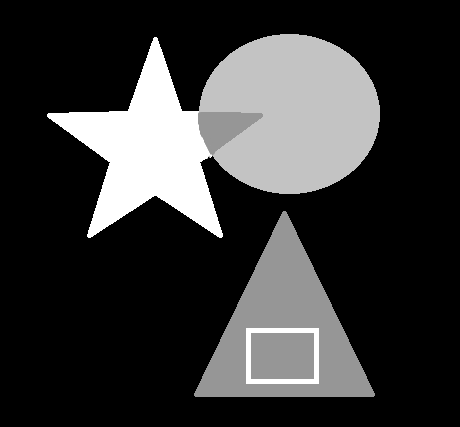


In [ ]:
X= data.camera().astype(np.float64)/255.0
m,n= X.shape
x= X.reshape(m*n)

#immagini generate
I1= imread('img_1.png', as_gray=True).astype(np.float64)
i1= I1.reshape(m*n)
I2= imread('img_2.png', as_gray=True).astype(np.float64)
i2= I2.reshape(m*n)
I3= imread('img_3.png', as_gray=True).astype(np.float64)
i3= I3.reshape(m*n)
I4= imread('img_4.png', as_gray=True).astype(np.float64)
i4= I4.reshape(m*n)
I5= imread('img_5.png', as_gray=True).astype(np.float64)
i5= I5.reshape(m*n)
I6= imread('img_6.png', as_gray=True).astype(np.float64)
i6= I6.reshape(m*n)
I7= imread('img_7.png', as_gray=True).astype(np.float64)
i7= I7.reshape(m*n)
I8= imread('img_8.png', as_gray=True).astype(np.float64)
i8= I8.reshape(m*n)

img_list= [I1, I2, I3, I4, I5, I6, I7, I8]
plt.figure(figsize=(30, 20))
i=0
while i<=len(img_list):
  if i==0:
    plt.subplot(3, 4, 1).imshow(X, cmap= "gray")
    plt.title('Immagine Originale Fotografo')
    i+=1
  else:
     plt.subplot(3, 4, i+1).imshow(img_list[i-1], cmap= 'gray')
     plt.title('Immagine Originale img_' + str(i))
     i+=1




## 1) Generazione immagini corrotte
Degradare le immagini applicando, mediante le funzioni riportate nella cella precedente,  l'operatore di blur con parametri

+ $\sigma=0.5$ dimensione $5\times 5$
+ $\sigma=1$ dimensione $7\times 7$
+ $\sigma=1.3$ dimensione $9\times 9$

ed aggiungendo rumore gaussiano con deviazione standard $(0,0.05]$

In [ ]:
header= ["imgName", "dimKer", "sigma", "noiseDev", "PSNR", "MSE" ] 
parameters= np.array([[5, 0.5, 0.02],[5, 0.5, 0.05],[5, 0.5, 0.10],[5, 0.5, 0.15],[5, 0.5, 0.30],
                      [7, 1, 0.02],[7, 1, 0.05],[7, 1, 0.10],[7, 1, 0.15],[7, 1, 0.30],
                      [9, 1.3, 0.02],[9, 1.3, 0.05],[9, 1.3, 0.10],[9, 1.3, 0.15],[9, 1.3, 0.30]])

for value in parameters:
  new_parameters= []
  counter= 65 
  K= psf_fft(gaussian_kernel(int(value[0]), value[1]), int(value[0]), X.shape)
  dev= value[2]
  noise= np.random.normal(size=X.shape) * dev

  X_blur= A(X, K)
  x_blur= X_blur.reshape(m*n)

  B= X_blur + noise
  b= B.reshape(m*n)

  X_PSNR= metrics.peak_signal_noise_ratio(X, B)
  X_MSE= metrics.mean_squared_error(X, B)

  #applicazione blur alle immagini generate
  I1_blur= A(I1, K) + noise
  i1_blur= I1_blur.reshape(m*n)
  I1_PSNR= metrics.peak_signal_noise_ratio(I1, I1_blur)
  I1_MSE= metrics.mean_squared_error(I1, I1_blur)

  I2_blur= A(I2, K) + noise
  i2_blur= I2_blur.reshape(m*n)
  I2_PSNR= metrics.peak_signal_noise_ratio(I2, I2_blur)
  I2_MSE= metrics.mean_squared_error(I2, I2_blur)

  I3_blur= A(I3, K) + noise
  i3_blur= I3_blur.reshape(m*n)
  I3_PSNR= metrics.peak_signal_noise_ratio(I3, I3_blur)
  I3_MSE= metrics.mean_squared_error(I3, I3_blur)

  I4_blur= A(I4, K) + noise
  i4_blur= I4_blur.reshape(m*n)
  I4_PSNR= metrics.peak_signal_noise_ratio(I4, I4_blur)
  I4_MSE= metrics.mean_squared_error(I4, I4_blur)

  I5_blur= A(I5, K) + noise
  i5_blur= I5_blur.reshape(m*n)
  I5_PSNR= metrics.peak_signal_noise_ratio(I5, I5_blur)
  I5_MSE= metrics.mean_squared_error(I5, I5_blur)

  I6_blur= A(I6, K) + noise
  i6_blur= I6_blur.reshape(m*n)
  I6_PSNR= metrics.peak_signal_noise_ratio(I6, I6_blur)
  I6_MSE= metrics.mean_squared_error(I6, I6_blur)

  I7_blur= A(I7, K) + noise
  i7_blur= I7_blur.reshape(m*n)
  I7_PSNR= metrics.peak_signal_noise_ratio(I7, I7_blur)
  I7_MSE= metrics.mean_squared_error(I7, I7_blur)

  I8_blur= A(I8, K) + noise
  i8_blur= I8_blur.reshape(m*n)
  I8_PSNR= metrics.peak_signal_noise_ratio(I8, I8_blur)
  I8_MSE= metrics.mean_squared_error(I8, I8_blur)

  blur_img_list= [I1_blur, I2_blur, I3_blur, I4_blur, I5_blur, I6_blur, I7_blur, I8_blur]
  blur_img_list2= [i1_blur, i2_blur, i3_blur, i4_blur, i5_blur, i6_blur, i7_blur, i8_blur]
  psnr_img_list= [I1_PSNR, I2_PSNR, I3_PSNR, I3_PSNR, I5_PSNR, I6_PSNR, I7_PSNR, I8_PSNR]
  mse_img_list= [I1_MSE, I2_MSE, I3_MSE, I4_MSE, I5_MSE, I6_MSE, I7_MSE, I8_MSE]

  new_parameters.append(["data.camera()", value[0], value[1], value[2], X_PSNR, X_MSE ])
  for i in range(8):
    new_parameters.append(["img_"+str(i+1) + "_blur",
                           value[0], value[1], value[2],
                           psnr_img_list[i], mse_img_list[i]])
  print(tabulate(new_parameters, headers=header, tablefmt="grid"))

  #calcolo media 
  avg_psnr= sum(psnr_img_list) / len(psnr_img_list)
  avg_mse= sum(mse_img_list) / len(mse_img_list)
  print('PSNR avg: ', avg_psnr)
  print('MSE avg: ', avg_mse)

  #calcolo std
  arr_psnr= np.array(psnr_img_list)
  arr_mse= np.array(mse_img_list)

  std_psnr= np.std(arr_psnr)
  std_mse= np.std(arr_mse)
  print('PSNR std: ', std_psnr)
  print('MSE std: ', std_mse)

  #stampo immagini generate nella versione originale e versione corrotta
  plt.figure(figsize=(60, 10))
  i= 0
  plot= 1
  while plot<=2*len(img_list)+2:
    try:
      if plot==1:
        plt.subplot(2, 9, plot).imshow(X, cmap='gray', vmin=0, vmax=1)
        plt.title('Immagine Originale Fotografo')
        i+=1
        plot+=1
      elif plot==10:
        plt.subplot(2, 9, plot).imshow(B, cmap='gray', vmin=0, vmax=1)
        plt.title('Immagine Corrotta Fotografo con PSNR:' + str(X_PSNR))
        i=1
        plot+=1
      elif plot<10:
        plt.subplot(2, 9, plot).imshow(img_list[i-1], cmap='gray')
        plt.title('Immagine  Originale img_' + str(i))
        i+=1
        plot+=1
      else:
        plt.subplot(2, 9, plot).imshow(blur_img_list[i-1], cmap='gray')
        plt.title('Immagine  Corrotta img_'+str(i) + '\nPSNR:' +str(psnr_img_list[i-1]) + ' MSE:' + str(mse_img_list[i-1]))
        plot+=1
        i+=1
    except ValueError:
      break  
  plt.show()







## 2) Soluzione naive

Una possibile ricostruzione dell'immagine originale $x$ partendo dall'immagine corrotta $b$ è la soluzione naive data dal minimo del seguente problema di ottimizzazione:
\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2
\end{align}

La funzione $f$ da minimizzare è data dalla formula
  $f(x) = \frac{1}{2} ||Ax - b||_2^2 $, il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb  $.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` calcolare la soluzione naive. 

In [ ]:
def f(x, B, lammbda=0):
  X= x.reshape(m, n)
  res= 0.5*(np.linalg.norm(A(X, K) - B))**2 + 0.5*lammbda*(np.linalg.norm(X))**2
  return np.sum(res)

def deltaf(x, B, lammbda= 0):
  X=x.reshape(m,n)
  res= AT(A(X, K)- B, K) + lammbda*X
  res1= np.reshape(res, m*n)
  return res1

iterations= np.arange(51)
iterations= iterations[1:]

#metodo del gradiente coniugato
valGrad_gradCon_list= []
errRel_gradCon_list= []
psnr_gradCon_list= []
valFun_gradCon_list= []

#immagine fotografo con gradiente coniugato
for i in iterations:
  func= lambda x: f(x, B)
  grad_func= lambda x: deltaf(x, B)
  res= minimize(func, np.zeros(b.shape), method="CG", jac= grad_func, options={'disp': True, 'maxiter': i})
  res1= res.x.reshape(m,n)
  PSNR= metrics.peak_signal_noise_ratio(X, res1)
  valGrad_gradCon_list.append(np.linalg.norm(res.jac.reshape(m,n), "fro"))
  errRel_gradCon_list.append(np.linalg.norm(res1 - X, "fro")/np.linalg.norm(X, "fro"))
  psnr_gradCon_list.append(PSNR)
  valFun_gradCon_list.append(res.fun)

func= lambda x: f(x, B)
grad_func= lambda x: deltaf(x, B)
res= minimize(func, np.zeros(b.shape), method="CG", jac= grad_func, options={'disp': True, 'maxiter':6})
res1= res.x.reshape(m,n)
psnr= metrics.peak_signal_noise_ratio(X, res1)

plt.figure(figsize=(60, 10))

plt.subplot(121).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title(f'Immagine Fotografo originale')
plt.subplot(122).imshow(res1, cmap="gray", vmin=0, vmax=1)
plt.title(f'Immagine Fotografo ricostruita con metodo del gradiente coniugato')
plt.show()




In [ ]:
#immagine geometriche con gradiente coniugato
plt.figure(figsize=(60,10))
i=0
plot=1
while plot<=2*len(img_list):
  if plot<=8:
      plt.subplot(2,8, plot).imshow(img_list[i], cmap='gray')
      plt.title('Immagine Originale img_'+ str (i+1))
      i+=1
      plot+=1
  else:
    if plot==9:
      i=0
    func= lambda x: f(x, blur_img_list[i])
    grad_func= lambda x: deltaf(x, blur_img_list[i])
    blur_img_list2_zeros= blur_img_list2[i]
    res= minimize(func, np.zeros(blur_img_list2_zeros.shape), method="CG", jac= grad_func, options={'disp': True, 'maxiter':5})
    res1=res.x.reshape(m,n)
    psnr= metrics.peak_signal_noise_ratio(img_list[i], res1)
    plt.subplot(2,8, plot).imshow(res1, cmap="gray", vmin=0, vmax=1)
    plt.title('Immagine img_' + str(i+1 )+ ' ricostruita con metodo del gradiente coniugato \n PSNR:' + str(psnr) )
    plot+=1
    i+=1
plt.show()

    


In [ ]:
#metodo del gradiente con backtracking
valGrad_grad_list= []
errRel_grad_list= []
psnr_grad_list= []
valFun_grad_list= []


def step_lenght(x, grad, B, lammbda= 0):
  alpha= 1.1
  c1= 0.25
  p= -grad
  j= 0
  jmax= 10
  #
  while ((f(x + alpha*p, B, lammbda) > f(x, B, lammbda) + c1*alpha*grad.T@p) and j<jmax):
    alpha= alpha*0.5
    j+=1
  return alpha

def grad_minimize(B, lammbda=0, maxit= 20, stop=1.e-6):
  x_zeros= np.zeros(m*n)
  k=0
  while (np.linalg.norm(deltaf(x_zeros, B, lammbda)) > stop and k<maxit):
    k+=1
    grad= deltaf(x_zeros, B, lammbda)
    step= step_lenght(x_zeros, grad, B, lammbda)

    valFun_grad_list.append(f(x_zeros, B))
    x_zeros-=step*grad

    valGrad_grad_list.append(np.linalg.norm(grad.reshape(m,n), "fro"))
    errRel_grad_list.append(np.linalg.norm(x_zeros.reshape(m,n) - X, "fro") / np.linalg.norm(X, "fro"))
    psnr_grad_list.append(metrics.peak_signal_noise_ratio(X, x_zeros.reshape(m,n)))
  return x_zeros

x_naive= grad_minimize(B, lammbda=0, maxit=50)
psnr= metrics.peak_signal_noise_ratio(X, x_naive.reshape(m,n))

plt.figure(figsize=(30,10))
plt.subplot(121).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title(f'Immagine Fotografo originale')
plt.subplot(122).imshow(x_naive.reshape(m,n), cmap='gray', vmin=0, vmax=1)
plt.title('Immagine fotografo ricostruita con metodo del gradiente PSNR:' + str(psnr))

plt.show()

In [ ]:
#immagini geometriche con metodo del gradiente con backtracking
plt.figure(figsize=(60,10))
i=0
plot=1
while plot<=2*len(img_list):
  if plot<=8:
    plt.subplot(2,8, plot).imshow(img_list[i], cmap='gray')
    plt.title(f'Immagine Originale img_' + str(i+1))
    i+=1
    plot+=1
  else:
    if plot==9:
      i=0
    img_naive= grad_minimize(blur_img_list[i])
    psnr= metrics.peak_signal_noise_ratio(img_list[i], img_naive.reshape(m,n))
    i+=1
    plt.subplot(2,8, plot).imshow(img_naive.reshape(m,n), cmap='gray')
    plt.title(f'Immagine img_' + str(i) + ' ricostruita con metodo del gradiente')
    plot+=1
plt.show()

## 3) Regolarizzazione
Per ridurre gli effetti del rumore nella ricostruzione è necessario introdurre un termine di regolarizzazione di Tikhonov. Si considera quindi il seguente problema di ottimizzazione.
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2
\end{align*}

La funzione $f$ da minimizzare diventa
$f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2$
il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb + λx$.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` ed il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 

In [ ]:
#immagine fototgrafo con metodo di regolarizzazione - lambda da 0,0000001 a 0,1
lammbda= list(np.linspace(1e-7, 1e-1, 100))
lambda_list= []
psnr_list= []
mse_list= []

psnr_avg= 0
psnr_max= [-9999, 0]
psnr_min= [9999, 0]
psnr_max_img= np.zeros((m,n))
psnr_min_img= np.zeros((m,n))

for i in range(100):
  fun= lambda x: f(x, B, lammbda[i])
  grad_fun= lambda x: deltaf(x, B, lammbda[i])
  res= minimize(fun, np.zeros(b.shape), method="CG", jac= grad_fun, options={'disp': True, 'maxiter':6})
  res1= res.x.reshape(m,n)

  psnr=metrics.peak_signal_noise_ratio(X, res1)
  mse= metrics.mean_squared_error(X, res1)

  psnr_list.append(psnr)
  mse_list.append(mse)
  
  psnr_max[0]=max(psnr_max[0], psnr)
  if psnr_max[0]== psnr:
    psnr_max_img= res1
    psnr_max[1]= lammbda[i]
  
  psnr_min[0]= min(psnr_min[0], psnr)
  if psnr_min[0]== psnr:
    psnr_min_img= res1
    psnr_min[1]= lammbda[i]
  
  lambda_list.append(lammbda[i])
  psnr_avg += psnr
  print(f'LAMBDA: ' + str(lammbda[i]) + ' PSNR: ' + str(psnr) + ' MSE: ' + str(mse))
print(f'PSNR_AVG: ' + str(psnr_avg/100))

fig, ax= plt.subplots(figsize=(10,15))

ax2= ax.twinx()
ax.plot(lambda_list, psnr_list, label='PSNR', color='green')
ax.plot(lambda_list, [psnr_avg/100 for i in range(100)], label='PSNR_AVG', color='red')
ax2.plot(lambda_list, mse_list, label='MSE', color='blue')

plt.title('Grafico ricostruzione con metodo di regolarizzazine immagine fotografo')
plt.legend(['PSNR', 'MSE'] , loc='upper right')
plt.grid()
ax.set_xlabel('LAMBDA')
ax.set_ylabel('PSNR & PSNR_AVG')

#plt.tight_layout()
plt.show()

plt.figure(figsize= (20, 60))
plt.subplot(131)
plt.title(f'immagine fotografo corrotta\nPSNR: ' + str(metrics.peak_signal_noise_ratio(X, B)))
plt.imshow(B, cmap='gray')
plt.subplot(132)
plt.title(f'Miglior immagine ottenuta con regolrizzazione\nPSNR: ' + str(psnr_max[0]) + '  LAMBDA: ' + str(psnr_max[1]))
plt.imshow(psnr_max_img, cmap='gray')
plt.subplot(133)
plt.title(f'Peggior immagine ottenuta con regolrizzazione\nPSNR: ' + str(psnr_min[0]) + '  LAMBDA: ' + str(psnr_min[1]))
plt.imshow(psnr_min_img, cmap='gray')
plt.show()

In [ ]:
#immagini geometriche con metodo regolarizzazione
counter= 65
lammbda= list(np.linspace(1e-7, 1e-1, 100))
alpha=0

while alpha<len(blur_img_list):
  lambda_list= []
  psnr_list= []
  mse_list= []

  psnr_avg= 0
  psnr_max= [-9999, 0]
  psnr_min= [9999, 0]
  psnr_max_img= np.zeros((m,n))
  psnr_min_img= np.zeros((m,n))

  for i in range(100):
    fun= lambda x: f(x, blur_img_list[alpha], lammbda[i])
    grad_fun= lambda x: deltaf(x, blur_img_list[alpha], lammbda[i])
    res= minimize(fun, np.zeros(blur_img_list2[alpha].shape), method='CG', jac=grad_fun, options={'disp': True, 'maxiter':6})
    res1= res.x.reshape(m,n)

    psnr= metrics.peak_signal_noise_ratio(img_list[alpha], res1)
    mse= metrics.mean_squared_error(img_list[alpha], res1)

    psnr_list.append(psnr)
    mse_list.append(mse)
    
    psnr_max[0]=max(psnr_max[0], psnr)
    if psnr_max[0]== psnr:
      psnr_max_img= res1
      psnr_max[1]= lammbda[i]
    
    psnr_min[0]= min(psnr_min[0], psnr)
    if psnr_min[0]== psnr:
      psnr_min_img= res1
      psnr_min[1]= lammbda[i]
    
    lambda_list.append(lammbda[i])
    psnr_avg += psnr

    print(f'img_' + str(alpha+1) + '\nLAMBDA: ' + str(lammbda[i]) + ' PSNR: ' + str(psnr) + ' MSE: ' +str(mse))
  
  print(f'PSNR_AVG: ' + str(psnr_avg/100))
  alpha+=1

  fig, ax= plt.subplots(figsize= (10, 5))

  ax2= ax.twinx()
  ax.plot(lambda_list, psnr_list, label='PSNR', color='green')
  ax.plot(lambda_list, [psnr_avg/100 for i in range(100)], label='PSNR_AVG', color='red')
  ax2.plot(lambda_list, mse_list, label='MSE', color='blue')

  plt.title('Grafico ricostruzione con metodo di regolarizzazine img_' + str(alpha))
  plt.legend(['PSNR', 'MSE'] , loc='upper right')
  plt.grid()
  ax.set_xlabel('LAMBDA')
  ax.set_ylabel('PSNR & PSNR_AVG')
  ax2.set_ylabel('MSE')

  plt.show()

  
  plt.figure(figsize=(20, 60))
  plt.subplot(131)
  plt.title(f'immagine corotta\nPSNR:' + str(metrics.peak_signal_noise_ratio(img_list[alpha-1], blur_img_list[alpha-1])))
  plt.imshow(blur_img_list[alpha-1], cmap='gray')
  plt.subplot(132)
  plt.title(f'Miglior immagine ottenuta con regolrizzazione\nPSNR: ' + str(psnr_max[0]) + '  LAMBDA: ' + str(psnr_max[1]))
  plt.imshow(psnr_max_img, cmap='gray')
  plt.subplot(133)
  plt.title(f'Peggior immagine ottenuta con regolrizzazione\nPSNR: ' + str(psnr_min[0]) + '  LAMBDA: ' + str(psnr_min[1]))
  plt.imshow(psnr_min_img, cmap='gray')
  plt.show()

In [ ]:
#immagine fotografo metodo di regolarizzazione - lambda da 0,00001 a 0,02
lammbda= list(np.linspace(1e-5, 2e-2, 100))

psnr_avg= 0
psnr_list= []
mse_list= []
psnr_max= [-9999, 0]
psnr_max_img= np.zeros((m,n))



for i in range(100):
  fun_min= grad_minimize(B, lammbda[i])
  psnr= metrics.peak_signal_noise_ratio(X, fun_min.reshape(m,n))
  mse= metrics.mean_squared_error(X, fun_min.reshape(m,n))
  
  psnr_max[0]=max(psnr_max[0], psnr)
  if psnr_max[0] == psnr:
    psnr_max_img= fun_min.reshape(m,n)
    psnr_max[1]= lammbda[i]
  

  psnr_avg+= psnr
  psnr_list.append(psnr)
  mse_list.append(mse)
  print('('+str(i) + ') LAMBDA: ' + str(lammbda[i]) + ' PSNR: ' + str(psnr))

fig, ax= plt.subplots(figsize=(10,5))
ax2= ax.twinx()
ax.plot(lammbda, psnr_list, label='PSNR', color='green')
ax.plot(lammbda, [psnr_avg/100 for i in range(100)], label='PSNR_AVG', color='red')
ax2.plot(lammbda, mse_list, label='MSE', color='blue')

plt.title('Grafico immagine Fotografo ricostruita con metodo di regolarizzazione')
plt.legend(['PSNR', 'MSE'], loc='upper right')
plt.grid()

ax.set_xlabel('LAMBDA')
ax.set_ylabel('PSNR & PSNR_AVG')
ax2.set_ylabel("MSE")
plt.show()

plt.figure(figsize=(20,60))
plt.subplot(121)
plt.title('Immagine corrotta \nPSNR: ' + str(metrics.peak_signal_noise_ratio(X, B)))
plt.imshow(B, cmap='gray')
plt.subplot(122)
plt.title('Migliore immagine ottenuta con gradiente regolarizzato \nPSNR:' + str(psnr_max[0]) + ' LAMBDA:' + str(psnr_max[1]))
plt.imshow(psnr_max_img, cmap='gray')
plt.show()

In [ ]:
#immagini geometriche con metodo di regolarizzazione - lambda da 0,00001 a 0,035
img_list= [I1, I2, I3, I4, I5, I6, I7, I8]
blur_img_list= [I1_blur, I2_blur, I3_blur, I4_blur, I5_blur, I6_blur, I7_blur, I8_blur]
alpha=0
lammbda= list(np.linspace(1e-5, 35e-3, 100))
while alpha<len(blur_img_list):
  psnr_avg=0
  psnr_list= []
  mse_list= []

  psn_max=[-9999, 0]
  psnr_max_img= np.zeros((m,n))

  for i in range(100):
    fun_min= grad_minimize(blur_img_list[alpha], lammbda[i])
    #fun_min= lambda x: grad_minimize(blur_img_list[alpha], lammbda[i])
    psnr= metrics.peak_signal_noise_ratio(img_list[alpha], fun_min.reshape(m,n))
    mse= metrics.mean_squared_error(img_list[alpha], fun_min.reshape(m,n))

    psnr_max[0]= max(psnr_max[0], psnr)
    if psnr_max[0]== psnr:
      psnr_max_img= fun_min.reshape(m,n)
      psnr_max[1]= lammbda[i]
    
    psnr_avg+= psnr
    psnr_list.append(psnr)
    mse_list.append(mse)
    print('(' + str(i) +')  img_' + str(alpha+1) + ' LAMBDA:' + str(lammbda[i]) + ' PSNR:' + str(psnr))
  
  fig, ax= plt.subplots(figsize=(10,5))
  ax2=ax.twinx()
  ax.plot(lammbda, psnr_list, label='PSNR', color='green')
  ax.plot(lammbda, [psnr_avg/100 for i in range(100)], label='PSNR_AVG', color='red')
  ax2.plot(lammbda, mse_list, label='MSE', color='blue')

  plt.title('Grafico immagine img_' + str(alpha+1) +' ricostruita con metodo di regolarizzazione')
  plt.legend(['PSNR', 'MSE'], loc='upper right')
  plt.grid()

  ax.set_xlabel('LAMBDA')
  ax.set_ylabel('PSNR & PSNR_AVG')
  ax2.set_ylabel("MSE")
  plt.show()

  plt.figure(figsize=(20,60))
  plt.subplot(121)
  plt.title('Immagine corrotta \nPSNR: ' + str(metrics.peak_signal_noise_ratio(img_list[alpha], blur_img_list[alpha])))
  plt.imshow(blur_img_list[alpha], cmap='gray')
  plt.subplot(122)
  plt.title('Migliore immagine ottenuta con gradiente regolarizzato \nPSNR:' + str(psnr_max[0]) + ' LAMBDA:' + str(psnr_max[1]))
  plt.imshow(psnr_max_img, cmap='gray')
  plt.show()

  alpha+=1

## 4) Variazione Totale (Facoltativo) 

Un altra funzione adatta come termine di regolarizzazione è la Variazione Totale. Data $u$ immagine di dimensioni $m\times n$ la variazione totale $TV$ di $u$ è definit come:
\begin{align*}
  TV(u) = \sum_i^n{\sum_j^m{\sqrt{||\nabla u(i, j)||_2^2 + \epsilon^2}}}
\end{align*}
Per calcolare il gradiente dell'immagine $\nabla u$ usiamo la funzione `np.gradient` che approssima la derivata per ogni pixel calcolando la differenza tra pixel adiacenti. I risultati sono due immagini della stessa dimensione dell'immagine in input, una che rappresenta il valore della derivata orizzontale `dx` e l'altra della derivata verticale `dy`. Il gradiente dell'immagine nel punto $(i, j)$ è quindi un vettore di due componenti, uno orizzontale contenuto in `dx` e uno verticale in `dy`.

Come nei casi precedenti il problema di minimo che si va a risolvere è il seguente:
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda TV(u)
\end{align*}
il cui gradiente $\nabla f$ è dato da
\begin{align*}
\nabla f(x) = (A^TAx - A^Tb)  + \lambda \nabla TV(x)
\end{align*}

Utilizzando il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 


---
Per risolvere il problema di minimo è necessario anche calcolare il gradiente della variazione totale che è definito nel modo seguente
\begin{align*}
  \nabla TV(u) = -div\left(\frac{\nabla u}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}\right)
\end{align*}

\begin{align*}
  div(F) = \frac{\partial F_x}{\partial x} + \frac{\partial F_y}{\partial y}
\end{align*}

$div(F)$ è la divergenza del campo vettoriale $F$, nel nostro caso $F$ ha due componenti dati dal gradiente dell'immagine $\nabla u$ scalato per il valore $ \frac{1}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}$. Per calcolare la divergenza bisogna calcolare la derivata orizzontale $\frac{\partial F_x}{\partial x}$ della componente $x$ di $F$ e sommarla alla derivata verticale $\frac{\partial F_y}{\partial y}$ della componente $y$ di $F$. Per specificare in quale direzione calcolare la derivata con la funzione `np.gradient` utilizziamo il parametro `axis = 0` per l'orizzontale e `axis = 1` per la verticale.

In [ ]:
eps = 1e-2

# Variazione totale
def totvar(x):
  # Calcola il gradiente di x
  dx, dy = np.gradient(x)
  n2 = np.square(dx) + np.square(dy)

  # Calcola la variazione totale di x
  tv = np.sqrt(n2 + eps**2).sum()
  return tv

# Gradiente della variazione totale
def grad_totvar(x):
  # Calcola il numeratore della frazione
  dx, dy = np.gradient(x)

  # Calcola il denominatore della frazione
  n2 = np.square(dx) + np.square(dy)
  den = np.sqrt(n2 + eps**2)

  # Calcola le due componenti di F dividendo il gradiente per il denominatore
  Fx = dx / den
  Fy = dy / den

  # Calcola la derivata orizzontale di Fx 
  dFdx = np.gradient(Fx, axis=0)
  
  # Calcola la derivata verticale di Fy
  dFdy = np.gradient(Fy, axis=1)

  # Calcola la divergenza 
  div = (dFdx + dFdy)

  # Restituisci il valore del gradiente della variazione totale
  return -div

# Relazione

1.   Riportare e commentare i risultati ottenuti nei punti 2. 3. (e 4.) su un immagine del set creato e su altre due immagini in bianco e nero  (fotografiche/mediche/astronomiche)
2.   Riportare delle tabelle con le misure di PSNR e MSE ottenute al variare dei parametri (dimensione kernel, valore di sigma, la deviazione standard del rumore, il parametro di regolarizzazione). 
3. Calcolare sull’intero set di immagini medie e deviazione standard delle metriche per alcuni valori fissati dei parametri.  
4. Analizzare su 2 esecuzioni le proprietà dei metodi numerici utilizzati (gradiente coniugato e gradiente) in termini di numero di iterazioni, andamento dell’errore, della funzione obiettivo, norma del gradiente. 

